<a href="https://colab.research.google.com/github/MaryamNourii/EmotionDetection/blob/Define_Train_Model/ED_SVM_EDds_fa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [3]:
data = pd.read_csv('/content/CleanData_arman.csv', sep=',')

In [5]:
class_names = ['SAD', 'HATE', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE', 'OTHER']
data['target'] = data['label'].map({'SAD':0, 'HATE':1, 'FEAR':2, 'ANGRY':3, 'HAPPY':4, 'SURPRISE':5, 'OTHER':6})
data_x = data['text']
data_y = data['target']

In [6]:
data['label'].value_counts(normalize=True)

SAD         0.177791
OTHER       0.176715
ANGRY       0.164719
HAPPY       0.135958
SURPRISE    0.132882
FEAR        0.123347
HATE        0.088588
Name: label, dtype: float64

In [7]:
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=0.1)

In [9]:
class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']

print('size of training set: %s' % (len(train_x)))
print('size of test set: %s' % (len(test_x)))


size of training set: 4680
size of test set: 1301


In [10]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [11]:
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

vect.fit_transform(train_x)

X_train_vect = vect.transform(train_x)
X_test_vect = vect.transform(test_x)

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 56.96%

F1 Score: 56.96

COnfusion Matrix:
 [[159   6   6  14  17   6  33]
 [ 16  64   1  15   1   7   7]
 [ 12   1 117  11   5   4  11]
 [ 22   6   1 129   5  13  35]
 [ 29   0   5   9  84  17  32]
 [ 22   2   9  15   6  72  32]
 [ 48   5  13  35  13  13 116]]


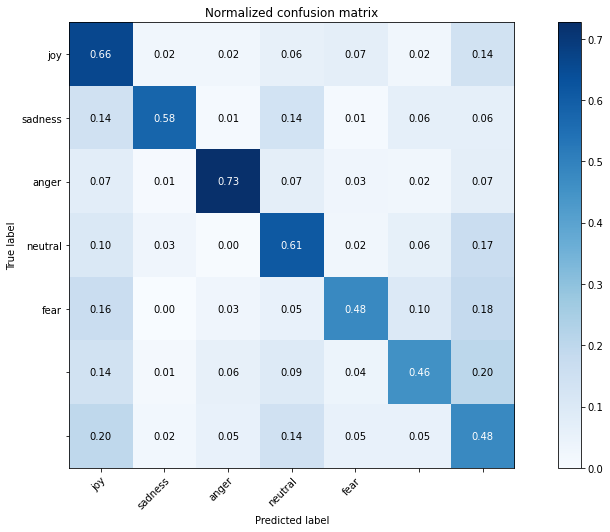

In [13]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, train_y)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(test_y, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_y, ylog_pred))

plot_confusion_matrix(test_y, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 58.88%

F1 Score: 58.88

COnfusion Matrix:
 [[147  11   6  13  27   6  31]
 [ 10  82   3   7   1   5   3]
 [  5   0 132   7   3   8   6]
 [ 20   6   3 127   9  18  28]
 [ 20   4   5   8  95  17  27]
 [ 19   3  14  13   8  82  19]
 [ 36  13  14  29  30  20 101]]


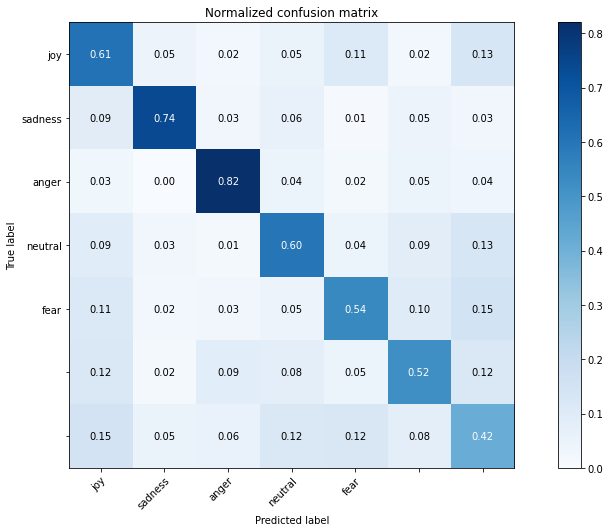

In [14]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, train_y)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(test_y, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_y, ysvm_pred))

plot_confusion_matrix(test_y, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()